Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картину известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картинки до контента.<br />
В качестве входа обычно используется зашумленная картинка контента.


Это все что нам понадобится:

Устанавливаем библиотеки, если ещё не установлены

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

Скачаем и разархивируем изображения.

Примеры изображений стиля и контента находятся в репозитории https://github.com/Alex-Norden/NST/ в папке data в подпапках style и content соответственно. Там же в подпапке result примеры выходных изображений.

In [2]:
! wget https://github.com/Alex-Norden/NST/raw/main/data.zip

--2021-01-17 11:47:50--  https://github.com/Alex-Norden/NST/raw/main/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alex-Norden/NST/main/data.zip [following]
--2021-01-17 11:47:50--  https://raw.githubusercontent.com/Alex-Norden/NST/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3059403 (2.9M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.92M  --.-KB/s    in 0.06s   

2021-01-17 11:47:51 (46.0 MB/s) - ‘data.zip’ saved [3059403/3059403]



In [3]:
!unzip -q data.zip

In [4]:
!ls

data  data.zip	sample_data


In [5]:
import os
import copy

%matplotlib inline
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import warnings
warnings.filterwarnings("ignore")

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE: {}".format(DEVICE))

DEVICE: cuda


# Вспомогательный класс для работы с изображениями

In [7]:
CONTENT_DIR = "data/content"
STYLE_DIR = "data/style"

for sub_dir in (CONTENT_DIR, STYLE_DIR):
  if not os.path.isdir(sub_dir):
      print("No such: {}".format(sub_dir))

In [8]:
RESULT_DIR = "data/result"
if not os.path.isdir(RESULT_DIR):
    try:
      os.makedirs(RESULT_DIR)
      print("Created directory: {}".format(RESULT_DIR))
    except OSError as e:
      print("Failed make directory: {}".format(e))

In [9]:
TARGET_SIZE = 256


class ImageManager(object):

    def __init__(self):
        super(ImageManager, self).__init__()
        self.content_source_size = None

        self.unloader = transforms.ToPILImage() #тензор в картинку

    def load_images(self, content_img_name, style_img_name, style2_img_name):
        content_img_path = os.path.join(CONTENT_DIR, content_img_name)
        style_img_path = os.path.join(STYLE_DIR, style_img_name)
        style2_img_path = os.path.join(STYLE_DIR, style2_img_name)
        
        img1 = Image.open(content_img_path)
        img2 = Image.open(style_img_path)
        img3 = Image.open(style2_img_path)

        self.content_source_size = img1.size

        scale = TARGET_SIZE / max(img1.size)
        img1 = img1.resize((round(img1.size[0] * scale), round(img1.size[1] * scale)), Image.ANTIALIAS)

        scale = TARGET_SIZE / min(img2.size)
        img2 = img2.resize((round(img2.size[0] * scale), round(img2.size[1] * scale)), Image.ANTIALIAS)

        scale = TARGET_SIZE / min(img3.size)
        img3 = img3.resize((round(img3.size[0] * scale), round(img3.size[1] * scale)), Image.ANTIALIAS)

        loader = transforms.Compose([
                    transforms.CenterCrop((img1.size[1], img1.size[0])), #нормируем размер изображения
                    transforms.ToTensor()])  #превращаем в удобный формат

        img1 = loader(img1).unsqueeze(0)
        img2 = loader(img2).unsqueeze(0)
        img3 = loader(img3).unsqueeze(0)

        return img1.to(DEVICE, torch.float), img2.to(DEVICE, torch.float), img3.to(DEVICE, torch.float)

    def show_image(self, tensor, title=None, save_result=False):
        """Отрисовка и сохранение
        """
        img = tensor.cpu().clone()
        img = img.squeeze(0)
        img = self.unloader(img)

        plt.figure()
        plt.imshow(img)
        if title is not None:
            plt.title(title)
        plt.grid(False)
        plt.axis('off')
        plt.show()

        if save_result:
            save_path = os.path.join(RESULT_DIR, "{}.jpg".format(title if title else "stylized"))

            if self.content_source_size is not None:
                img = img.resize(self.content_source_size, Image.ANTIALIAS)
            else:
                print("Invalid content_source_size: {}".format(self.content_source_size))

            img.save(save_path)

# Loss

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполнены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ошибка input'а и target'а

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach() #это константа. Убираем ее из дерева вычислений
        self.loss = F.mse_loss(self.target, self.target) #to initialize with something

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и корреляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем способ подсчета матрицы грама: Это просто тензорное произведение вектора выхода уровня самого на себя.<br /> Однако, наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [11]:
def gram_matrix(input):
    batch_size , h, w, f_map_num = input.size()  # batch size(=1)
    # b=number of feature maps
    # (h,w)=dimensions of a feature map (N=h*w)

    features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(batch_size * h * w * f_map_num)

In [12]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature, use_mask=False, invert_mask=None):
        super(StyleLoss, self).__init__()
        
        if use_mask:
            self.mask = torch.zeros_like(target_feature, dtype=torch.bool)
            self.mask[:, :, :, :target_feature.shape[-1] // 2] = True
            if invert_mask:
                self.mask = ~self.mask

            self.mask = self.mask.detach()
            self.target = gram_matrix(target_feature * self.mask).detach()
        else:
            self.mask = None
            self.target = gram_matrix(target_feature).detach()
 
        self.loss = F.mse_loss(self.target, self.target) #to initialize with something

    def forward(self, input):
        if self.mask is not None:
            G = gram_matrix(input * self.mask)
        else:
            G = gram_matrix(input)
        
        self.loss = F.mse_loss(G, self.target)
        return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим использовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

In [14]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем считать ошибки стиля, а после каких ошибки контента

In [15]:
content_layers_default = ('conv_4',)
style_layers_default = ('conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5')

Определим предобученную модель

In [16]:
vgg19 = models.vgg19(pretrained=True).features.to(DEVICE).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


# Сборка модели

In [17]:
STYLIZE_MODES = range(4)
STYLIZE_FIRST, STYLIZE_SECOND, STYLIZE_HALF, STYLIZE_MIX = STYLIZE_MODES

In [18]:
class StyleTransfer(object):
    def __init__(self, cnn, normalization_mean, normalization_std, content_layers, style_layers, content_img, style_img, style2_img):
        super(StyleTransfer, self).__init__()

        self.cnn = cnn
        self.normalization_mean = normalization_mean
        self.normalization_std = normalization_std

        self.content_layers = content_layers
        self.style_layers = style_layers

        self.model = None
        self.step = 0

        self.content_losses = []
        self.style_losses = []
        self.style2_losses = []

        self.content_img = content_img
        self.style_img = style_img
        self.style2_img = style2_img

        self.mode = None

    def build_model(self, mode):
        print('Building the style transfer model..')

        if mode not in STYLIZE_MODES:
            raise ValueError("Invalid mode: {}".format(mode))

        use_mask = True if mode == STYLIZE_HALF else False

        # just in order to have an iterable access to list of content/style losses
        self.content_losses.clear()
        self.style_losses.clear()
        self.style2_losses.clear()

        cnn = copy.deepcopy(self.cnn)

        # normalization module
        normalization = Normalization(self.normalization_mean, self.normalization_std).to(DEVICE)

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0 # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in self.content_layers:
                # add content loss:
                content_feature = model(self.content_img).detach()
                content_loss = ContentLoss(content_feature)
                model.add_module("content_loss_{}".format(i), content_loss)
                self.content_losses.append(content_loss)

            if name in self.style_layers:
                # add style loss:
                if mode != STYLIZE_SECOND:
                    style_feature = model(self.style_img).detach()
                    style_loss = StyleLoss(style_feature, use_mask, invert_mask=False)
                    model.add_module("style_loss_{}".format(i), style_loss)
                    self.style_losses.append(style_loss)

                if mode != STYLIZE_FIRST:
                    style2_feature = model(self.style2_img).detach()
                    style2_loss = StyleLoss(style2_feature, use_mask, invert_mask=True)
                    model.add_module("style2_loss_{}".format(i), style2_loss)
                    self.style2_losses.append(style2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последнего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        self.model = model[:(i + 1)]
        self.mode = mode

    @staticmethod
    def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добавляет содержимое тензора картинки в список изменяемых оптимизатором параметров
        return optim.LBFGS([input_img.requires_grad_()])

    def run(self, num_steps, content_weight, style_weight, style2_weight):
        """
        Run the style transfer
        """
        def closure():
            # correct the values
            # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()

            self.model(input_img)

            content_score = 0
            style_score = 0
            style2_score = 0

            for cl in self.content_losses:
                content_score += cl.loss

            #взвешивание ошибки на контенте
            content_score *= content_weight

            if self.mode != STYLIZE_SECOND:
                for sl in self.style_losses:
                    style_score += sl.loss
                #взвешивание ошибки на стиле 1
                style_score *= style_weight

            if self.mode != STYLIZE_FIRST:
                for sl2 in self.style2_losses:
                    style2_score += sl2.loss
                #взвешивание ошибки на стиле 2
                style2_score *= style2_weight

            loss = content_score

            if self.mode == STYLIZE_FIRST:
                loss += style_score
            elif self.mode == STYLIZE_SECOND:
                loss += style2_score
            else:
                loss += style_score + style2_score

            loss.backward()

            self.step += 1
            if self.step % 50 == 0:
                print(log_pattern.format(
                    self.step, content_score.item(),
                    style_score if isinstance(style_score, int) else style_score.item(),
                    style2_score if isinstance(style2_score, int) else style2_score.item()))

            return loss

        if self.mode is None:
            raise ValueError("No init mode: {}".format(self.mode))

        input_img = self.content_img.clone().detach()
        optimizer = self.get_input_optimizer(input_img)

        log_pattern = 'Step: {}\tContent Loss: {:.4f} Style Loss: {:.4f} Style 2 Loss: {:.4f}'
        print('Optimizing..')
        self.step = 0
        while self.step <= num_steps:
            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img.cpu().detach()

Цикл обучения стандартный, за исключением функции closure.

Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получится,так как у нас своя функция ошибки

# Загрузка изображений

In [19]:
img_manager = ImageManager()

In [20]:
content_img_name = "girl.jpg"
style_img_name = "mosaic.jpg"
style2_img_name = "vg_starry_night.jpg"

content_img, style_img, style2_img = img_manager.load_images(content_img_name, style_img_name, style2_img_name)

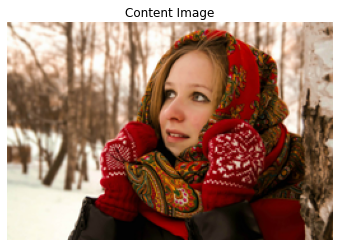

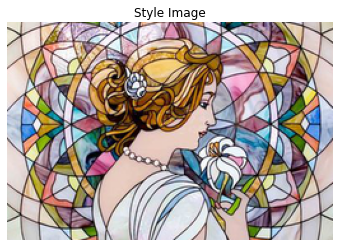

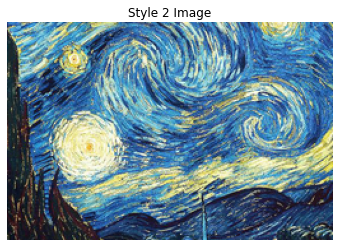

In [24]:
#отрисовка
img_manager.show_image(content_img, title='Content Image')

img_manager.show_image(style_img, title='Style Image')

img_manager.show_image(style2_img, title='Style 2 Image')

# Обучение

In [22]:
style_transfer = StyleTransfer(vgg19, 
                              cnn_normalization_mean, cnn_normalization_std,
                              content_layers_default,
                              style_layers_default,
                              content_img, style_img, style2_img)

In [23]:
def stylize(mode):
    style_transfer.build_model(mode)
    return style_transfer.run(
                   num_steps=300,
                   content_weight=1,
                   style_weight=1e5,
                   style2_weight=2e5)

## Применение стилей по одному

Building the style transfer model..
Optimizing..
Step: 50	Content Loss: 136.9046 Style Loss: 67.4763 Style 2 Loss: 0.0000
Step: 100	Content Loss: 83.2905 Style Loss: 17.2402 Style 2 Loss: 0.0000
Step: 150	Content Loss: 71.7339 Style Loss: 11.0603 Style 2 Loss: 0.0000
Step: 200	Content Loss: 65.9249 Style Loss: 8.4944 Style 2 Loss: 0.0000
Step: 250	Content Loss: 62.7132 Style Loss: 7.6449 Style 2 Loss: 0.0000
Step: 300	Content Loss: 60.9898 Style Loss: 7.9634 Style 2 Loss: 0.0000


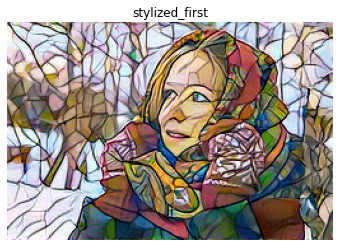

In [25]:
stylized_img = stylize(STYLIZE_FIRST)
img_manager.show_image(stylized_img, title='stylized_first', save_result=True)

Building the style transfer model..
Optimizing..
Step: 50	Content Loss: 85.7800 Style Loss: 0.0000 Style 2 Loss: 34.2142
Step: 100	Content Loss: 44.2150 Style Loss: 0.0000 Style 2 Loss: 6.7892
Step: 150	Content Loss: 34.7413 Style Loss: 0.0000 Style 2 Loss: 4.3903
Step: 200	Content Loss: 30.5712 Style Loss: 0.0000 Style 2 Loss: 3.4204
Step: 250	Content Loss: 28.3033 Style Loss: 0.0000 Style 2 Loss: 2.8749
Step: 300	Content Loss: 27.1152 Style Loss: 0.0000 Style 2 Loss: 2.5908


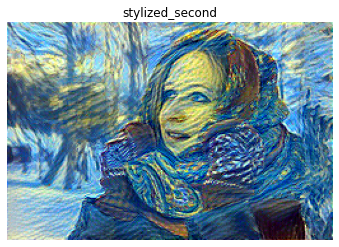

In [26]:
stylized_img = stylize(STYLIZE_SECOND)
img_manager.show_image(stylized_img, title='stylized_second', save_result=True)

## Применение двух стилей к разным частям

Building the style transfer model..
Optimizing..
Step: 50	Content Loss: 107.1160 Style Loss: 23.0597 Style 2 Loss: 24.2254
Step: 100	Content Loss: 62.2854 Style Loss: 6.8180 Style 2 Loss: 5.5572
Step: 150	Content Loss: 53.5548 Style Loss: 4.9202 Style 2 Loss: 3.2757
Step: 200	Content Loss: 49.6500 Style Loss: 4.4313 Style 2 Loss: 2.6082
Step: 250	Content Loss: 47.2611 Style Loss: 3.7347 Style 2 Loss: 2.2242
Step: 300	Content Loss: 46.7426 Style Loss: 4.3787 Style 2 Loss: 2.3233


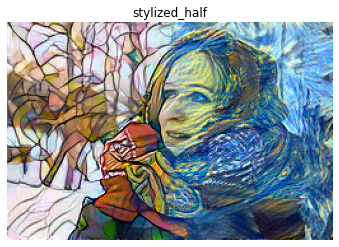

In [27]:
stylized_img = stylize(STYLIZE_HALF)
img_manager.show_image(stylized_img, title='stylized_half', save_result=True)

## Применение двух стилей вместе

Building the style transfer model..
Optimizing..
Step: 50	Content Loss: 21429.5469 Style Loss: 14191.6396 Style 2 Loss: 7184.2246
Step: 100	Content Loss: 21342.8965 Style Loss: 14208.0547 Style 2 Loss: 7085.5908
Step: 150	Content Loss: 21328.8574 Style Loss: 14194.8340 Style 2 Loss: 7092.7241
Step: 200	Content Loss: 21322.3730 Style Loss: 14191.1270 Style 2 Loss: 7094.3101
Step: 250	Content Loss: 21318.6445 Style Loss: 14206.7148 Style 2 Loss: 7077.6699
Step: 300	Content Loss: 21316.3301 Style Loss: 14201.5518 Style 2 Loss: 7082.1562


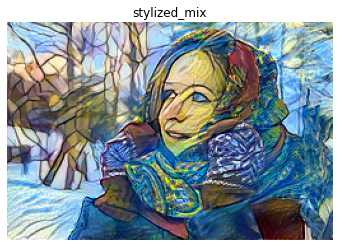

In [28]:
stylized_img = stylize(STYLIZE_MIX)
img_manager.show_image(stylized_img, title='stylized_mix', save_result=True)